# The Magnitude limit of an Astronomical Image.

The `assets/01-noise.fits` file is a fake, background-subtracted image of an empty patch of sky (it's actually just gaussian noise). The pixels have size $0.^"3$ on a side and its values are in units of $nJy$. What is the $1\sigma$ limiting magnitude on $2.^"5$-diameter apertures?

It will be useful to install the `Photutils` package: https://photutils.readthedocs.io/en/stable/install.html

## Let's take a look at the fake image first

In [1]:
%matplotlib inline
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(2341)

The following is general information about the structure of the file:

Filename: assets/01-noise.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       6   (200, 200)   float64   
None


-----------------------------
Below is the header of the first HDU:

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  200                                                  
NAXIS2  =                  200                                                  
EXTEND  =                    T                                                  


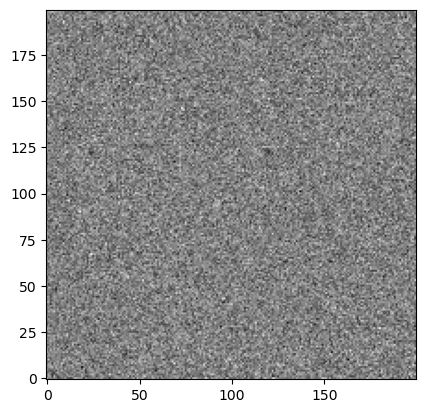

In [2]:
img = fits.open('assets/01-noise.fits')

print("The following is general information about the structure of the file:\n")
print(img.info())

print("\n\n-----------------------------")
print("Below is the header of the first HDU:\n")
print(repr(img[0].header))

data = img[0].data

with plt.style.context("default"):
    plt.imshow(data, cmap='gray', origin='lower')

## Let's create a fake source to understand the concept of limiting magnitude

We will create a point source that has a gaussian profile (stars don't look like this in reality). The source has a FWHM~2".

In [3]:
xx, yy = np.meshgrid(np.arange(-10, 11), np.arange(-10, 11))
g = np.exp(-(xx**2 + yy**2) / 2 / (0.85/0.3)**2)
g /= np.sum(g)  # This is just normalizing the total flux

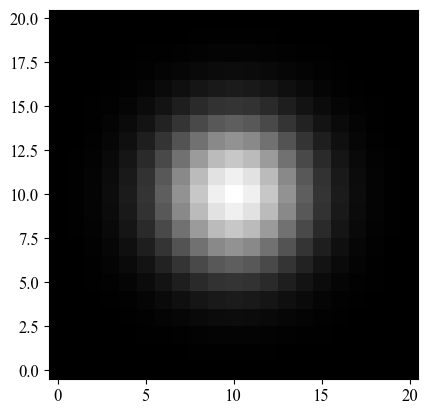

In [4]:
plt.imshow(g, cmap='gray', origin='lower');

Now we will normalize the flux within a 2.5" aperture.

In [5]:
from photutils import CircularAperture, aperture_photometry

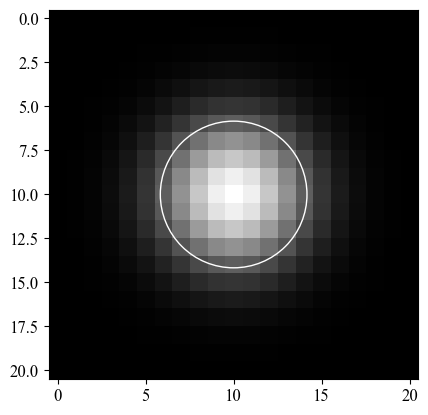

In [6]:
aperture_diameter_arcsecs = 2.5
pixel_scale = 0.3 # arcsecs/pixel
aperture_radius = 2.5 / pixel_scale / 2

central_aperture = CircularAperture((10,10), r=aperture_radius)

plt.imshow(g, cmap='gray')
central_aperture.plot(color='w')

The white circle is the 2.5" aperture. We will measure all the flux inside that aperture

In [7]:
flux_in_25 = aperture_photometry(g, central_aperture)
print(flux_in_25)

 id xcenter ycenter    aperture_sum   
      pix     pix                     
--- ------- ------- ------------------
  1    10.0    10.0 0.6560418659060616


In [8]:
g = g / flux_in_25['aperture_sum']  # We normalize so that now the flux inside the aperture is 1.

## Adding the fake source to our fake noise image.

In [9]:
x = y = 50
patched = data.copy()
patched[x-10:x+11, y-10:y+11] += (g * 351.985 * 20)

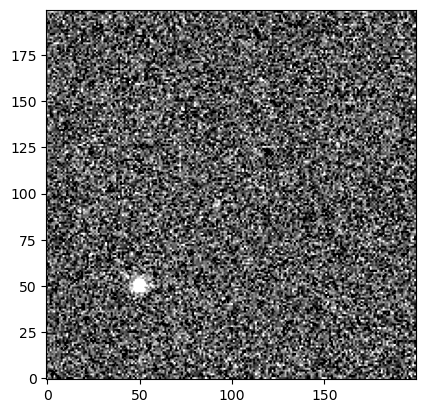

In [10]:
with plt.style.context("default"):
    plt.imshow(patched, cmap='gray', origin='lower', vmin=-50, vmax=100)

## How much fainter can the source be, so that we can still see it?

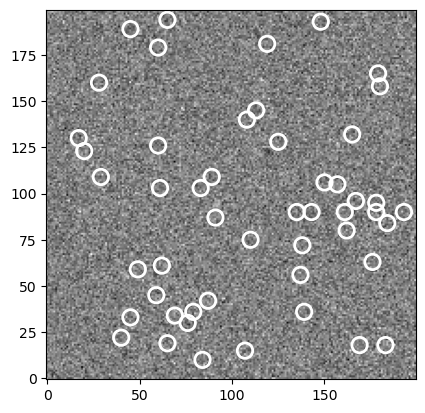

In [11]:
aperture_diameter_arcsecs = 2.5
pixel_scale = 0.3 # arcsecs/pixel
aperture_radius = 2.5 / pixel_scale / 2

min_center = int(np.ceil(aperture_radius))
max_center = int(np.floor(data.shape[0]-aperture_radius))

N_apertures = 50
x_centers = np.random.randint(min_center, max_center, size=N_apertures)
y_centers = np.random.randint(min_center, max_center, size=N_apertures)

random_apertures = CircularAperture(zip(x_centers, y_centers), r=aperture_radius)

with plt.style.context("default"):
    plt.imshow(data, cmap='gray', origin='lower')
    random_apertures.plot(color='w', lw=2)

In [12]:
photometry = aperture_photometry(data, random_apertures)
print(photometry)

 id xcenter ycenter     aperture_sum   
      pix     pix                      
--- ------- ------- -------------------
  1   179.0   165.0   65.76403351436767
  2   135.0    90.0 -236.01764107675746
  3   178.0    90.0 -25.235345580972876
  4   137.0    56.0   37.17786906796272
  5    76.0    30.0  -567.0132513868001
  6    79.0    36.0  -4.487119191304487
  7   113.0   145.0 -487.47796079753226
  8   183.0    18.0   616.2300026104599
  9    49.0    59.0  292.01492931672703
 10    17.0   130.0 -125.76983243820513
...     ...     ...                 ...
 41   176.0    63.0  -51.66603168219976
 42   167.0    96.0   121.6707969374676
 43   184.0    84.0  -262.9694399449562
 44    84.0    10.0  157.20879557220815
 45   157.0   105.0   287.2757776048193
 46    60.0   126.0  -411.2450779522811
 47    45.0   189.0   -696.435475498841
 48   193.0    90.0  -511.9610717718488
 49    89.0   109.0 -109.15130941374429
 50   110.0    75.0 -325.32857145628316
Length = 50 rows


The std of the fluxes: 351.985


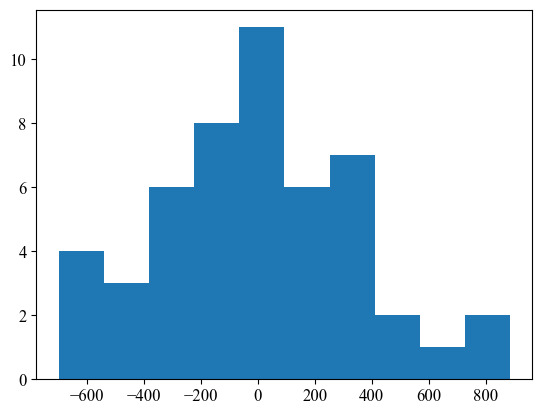

In [13]:
fluxes = photometry['aperture_sum'].data
plt.hist(fluxes, bins=10)

fluxes_std = fluxes.std(ddof=1)
print('The std of the fluxes: {:.3f}'.format(fluxes_std))

In [14]:
mag_lim = 31.4 - 2.5 * np.log10(fluxes_std) # Here 31.4 is the AB zeropoint for nJy

print('The corresponding 1 sigma limiting magnitude is: {:.2f}'.format(mag_lim))

The corresponding 1 sigma limiting magnitude is: 25.03
